In [1]:
from jaxl.constants import *
from jaxl.datasets import get_dataset
from jaxl.learning_utils import get_learner
from jaxl.models.svm import *
from jaxl.plot_utils import set_size
from jaxl.utils import parse_dict

import copy
import jax
import jax.numpy as jnp
import jax.random as jrandom
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import optax
import os

from functools import partial
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager

plt.style.use("seaborn")

/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_90464/2064469505.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
base_dir = "/Users/chanb/research/personal/jaxl/jaxl"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/default-09-15-23_10_06_09-d24e0ff2-341c-4899-b5ae-4f9406de2e45"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/hinge-09-15-23_10_06_20-cc99805e-ba12-41b3-9ee8-faf49561f1e2"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/default-09-15-23_11_41_01-9b69642a-9398-49b5-adb5-b575f83f19eb"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/hinge-09-15-23_15_35_25-1b7a7c97-99c3-4853-8691-3c6b74846f05"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/permutation-09-15-23_10_06_22-034a967f-8de1-47be-9bdc-2d7cd1626c5a"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/hinge-09-15-23_18_01_46-e5f7d4fc-283e-4f43-bb1b-befd3d60487b"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/permutation-09-15-23_18_12_21-df299a07-b07a-4628-aafb-946a104a0302"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/no_pos_enc-09-15-23_18_01_44-d429a4bb-9dfd-4b92-92c8-410a2c8eccca"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/query_pred_only-09-19-23_13_19_07-8d80ce8e-9580-485e-b794-1ca151be6f04"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/query_pred_only-large_batch-09-19-23_20_25_35-bf402d3b-a6c8-4108-8f9d-06a242375974/"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/query_pred_only-large_batch-hinge-09-20-23_07_42_25-91913a35-27ed-4123-bd45-b4388b7de9e0"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/margin-09-20-23_15_18_26-989ae10a-2243-418b-b2b3-f69391b4eb30"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/query_pred_only-margin-09-21-23_00_07_11-d3b5ac68-d03c-4b42-92d9-aaf0913ab0da"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/permutation-margin-09-21-23_00_07_26-0b016292-20fb-4155-a863-55192a6771c8"
# rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/margin-09-21-23_00_07_37-5aabbbfd-0462-4263-b7ca-b6527e90a0bb"
rel_path = "logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_20/query_pred_only-09-28-23_09_58_47-b2e9bf6d-8d2e-475a-b2a3-a0fd7ada8628/"
learner_path = os.path.join(
    base_dir, rel_path
)
test_dataset_seed = 999
sequence_len = 40
# num_tasks = 30
num_tasks = 1

# For plotting
doc_width_pt = 1000.0

In [3]:
config_path = os.path.join(learner_path, "config.json")
with open(config_path, "r") as f:
    config_dict = json.load(f)
    config = parse_dict(config_dict)

query_pred_only = getattr(config.model_config, "query_pred_only", False)
if query_pred_only:
    def process_prediction(preds):
        return preds[:, -1]
else:
    def process_prediction(preds):
        return preds[:, 0, -1]

learner = get_learner(
    config.learner_config, config.model_config, config.optimizer_config
)

checkpoint_manager = CheckpointManager(
    os.path.join(learner_path, "models"),
    PyTreeCheckpointer(),
)

params = checkpoint_manager.restore(checkpoint_manager.latest_step())
params[CONST_MODEL_DICT][CONST_MODEL][CONST_POSITIONAL_ENCODING] = dict()
llm_model = learner._model

In [4]:
config.learner_config.dataset_config

namespace(dataset_name='multitask_nd_linear_classification',
          dataset_kwargs=namespace(input_dim=2,
                                   num_sequences=100000,
                                   sequence_length=41,
                                   noise=0.0,
                                   params_bound=[-10.0, 10.0],
                                   num_active_params=None,
                                   val_frac=0.0005),
          dataset_wrapper=namespace(type='ContextDataset',
                                    kwargs=namespace(context_len=20)))

In [5]:
input_range = [-1.0, 1.0]
ns_test_config = copy.deepcopy(vars(config.learner_config.dataset_config))

ns_test_config["dataset_wrapper"] = vars(ns_test_config["dataset_wrapper"])
ns_test_config["dataset_wrapper"]["type"] = "FixedLengthContextDataset"
ns_test_config["dataset_wrapper"] = parse_dict(ns_test_config["dataset_wrapper"])

ns_test_config["dataset_kwargs"] = vars(ns_test_config["dataset_kwargs"])
ns_test_config["dataset_kwargs"]["num_sequences"] = num_tasks
ns_test_config["dataset_kwargs"]["sequence_length"] = sequence_len
ns_test_config["dataset_kwargs"]["params_bound"] = [-0.5, 0.5]
ns_test_config["dataset_kwargs"]["inputs_range"] = input_range
# ns_test_config["dataset_kwargs"]["margin"] = 0.5
ns_test_config["dataset_kwargs"] = parse_dict(ns_test_config["dataset_kwargs"])
ns_test_config = parse_dict(ns_test_config)

In [6]:
test_dataset = get_dataset(ns_test_config, seed=test_dataset_seed)
unwrapped_dataset = test_dataset._dataset

In [7]:
context_len = config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len


def get_result(dataset, task_i, context_len):
    context_inputs, context_outputs = [], []
    for context_i in range(context_len):
        context_inputs.append(dataset._inputs[task_i, context_i])
        context_outputs.append(dataset._targets[task_i, context_i])
    context_inputs = np.stack(context_inputs)
    context_outputs = np.stack(context_outputs)

    queries = dataset._inputs[task_i, context_len:]
    outputs = dataset._targets[task_i, context_len:]

    preds, _ = jax.vmap(llm_model.forward, in_axes=[None, 0, None])(
        params[CONST_MODEL_DICT][CONST_MODEL],
        queries[:, None, None],
        {
            CONST_CONTEXT_INPUT: context_inputs[None, :],
            CONST_CONTEXT_OUTPUT: context_outputs[None, :],
        },
    )
    return queries, preds, outputs, context_inputs, context_outputs

In [8]:
def ce_loss(logits, y_one_hot):
    return np.mean(optax.softmax_cross_entropy(logits, y_one_hot))

# Analysis

In [9]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [10]:
res = {}

for task_i in range(num_tasks):
    queries, preds, outputs, context_inputs, context_outputs = get_result(
        unwrapped_dataset, task_i, context_len
    )
    preds = process_prediction(preds)
    loss = ce_loss(preds, outputs)
    res.setdefault(task_i, {})
    res[task_i]["data"] = {
        "context_inputs": context_inputs,
        "context_outputs": context_outputs,
        "queries": queries,
        "outputs": outputs,
    }
    res[task_i]["llm"] = preds

    gt = test_dataset.params[task_i]
    res[task_i]["gt"] = -np.array(input_range) * gt[1] / gt[2]


In [11]:
svm_regs = [1e-2, 1e-1, 5e-1, 1.0, 2.0, 10.0, 100.0, 1000.0]
lr_regs = [1e-2, 1e-1, 5e-1, 1.0, 2.0, 10.0, 100.0, 1000.0]
knn_ks = [1, 3]

### K-NN

In [12]:
def make_knn(inputs, outputs, num_neighbours):
    knn = make_pipeline(
        KNeighborsClassifier(
            n_neighbors=num_neighbours,
        )
    )
    knn.fit(inputs, np.argmax(outputs, axis=1))
    return knn

In [13]:
for task_i in range(num_tasks):
    knns = {}
    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    for idx, k in enumerate(knn_ks):

        knns[k] = make_knn(context_inputs, context_outputs, k)

    res[task_i]["knn"] = knns

### SVM

In [14]:
def make_svm(inputs, outputs, reg_coef):
    svm = make_pipeline(
        LinearSVC(
            C=reg_coef,
            max_iter=2000,
        ),
    )
    svm.fit(inputs, np.argmax(outputs, axis=1))
    return svm

In [15]:
svm_info = {}

for task_i in range(num_tasks):
    svms = {}
    svm_info.setdefault(task_i, {})

    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    for idx, svm_reg in enumerate(svm_regs):
        svms[svm_reg] = make_svm(context_inputs, context_outputs, svm_reg)

        decision_function = svms[svm_reg].decision_function(context_inputs)
        support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
        support_vectors = context_inputs[support_vector_indices]

        svm_info[task_i][svm_reg] = {
            "support_vectors": support_vectors,
            "support_labels": context_outputs[support_vector_indices],
            "support_vector_indices": support_vector_indices,
        }

    res[task_i]["svm"] = svms

/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expli

### Logistic Regression

In [16]:
def make_lr(inputs, outputs, penalty, reg_coef):
    logistic_regression = make_pipeline(LogisticRegression(
        penalty=penalty,
        C=reg_coef,
        max_iter=2000,
    ))
    logistic_regression.fit(inputs, np.argmax(outputs, axis=1))
    return logistic_regression

In [17]:
for task_i in range(num_tasks):
    lrs = {}

    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    for idx, lr_reg in enumerate(lr_regs):
        lrs[lr_reg] = make_lr(context_inputs, context_outputs, "l2", lr_reg)
    res[task_i]["lr"] = lrs

### ICL Analysis

In [18]:
model_preds = {}
num_models = len(lr_regs) + len(svm_regs)

delta = 0.01
xs_grid = np.arange(-1.0, 1.0 + delta, delta)
test_queries = np.stack(np.meshgrid(xs_grid, xs_grid)).reshape((2, -1)).T

In [19]:
for task_i in range(num_tasks):
    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    model_preds.setdefault(task_i, {})
    llm_preds, _ = jax.vmap(llm_model.forward, in_axes=[None, 0, None])(
        params[CONST_MODEL_DICT][CONST_MODEL],
        test_queries[:, None, None],
        {
            CONST_CONTEXT_INPUT: context_inputs[None, :],
            CONST_CONTEXT_OUTPUT: context_outputs[None, :],
        },
    )
    llm_preds = process_prediction(llm_preds)
    model_preds[task_i]["llm"] = llm_preds
    model_preds[task_i]["gt"] = np.eye(2)[(
        (
            test_queries @ test_dataset.params[task_i, 1:]
            + test_dataset.params[task_i, :1]
        )
        >= 0
    ).flatten().astype(int)]

/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_90464/1995947790.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


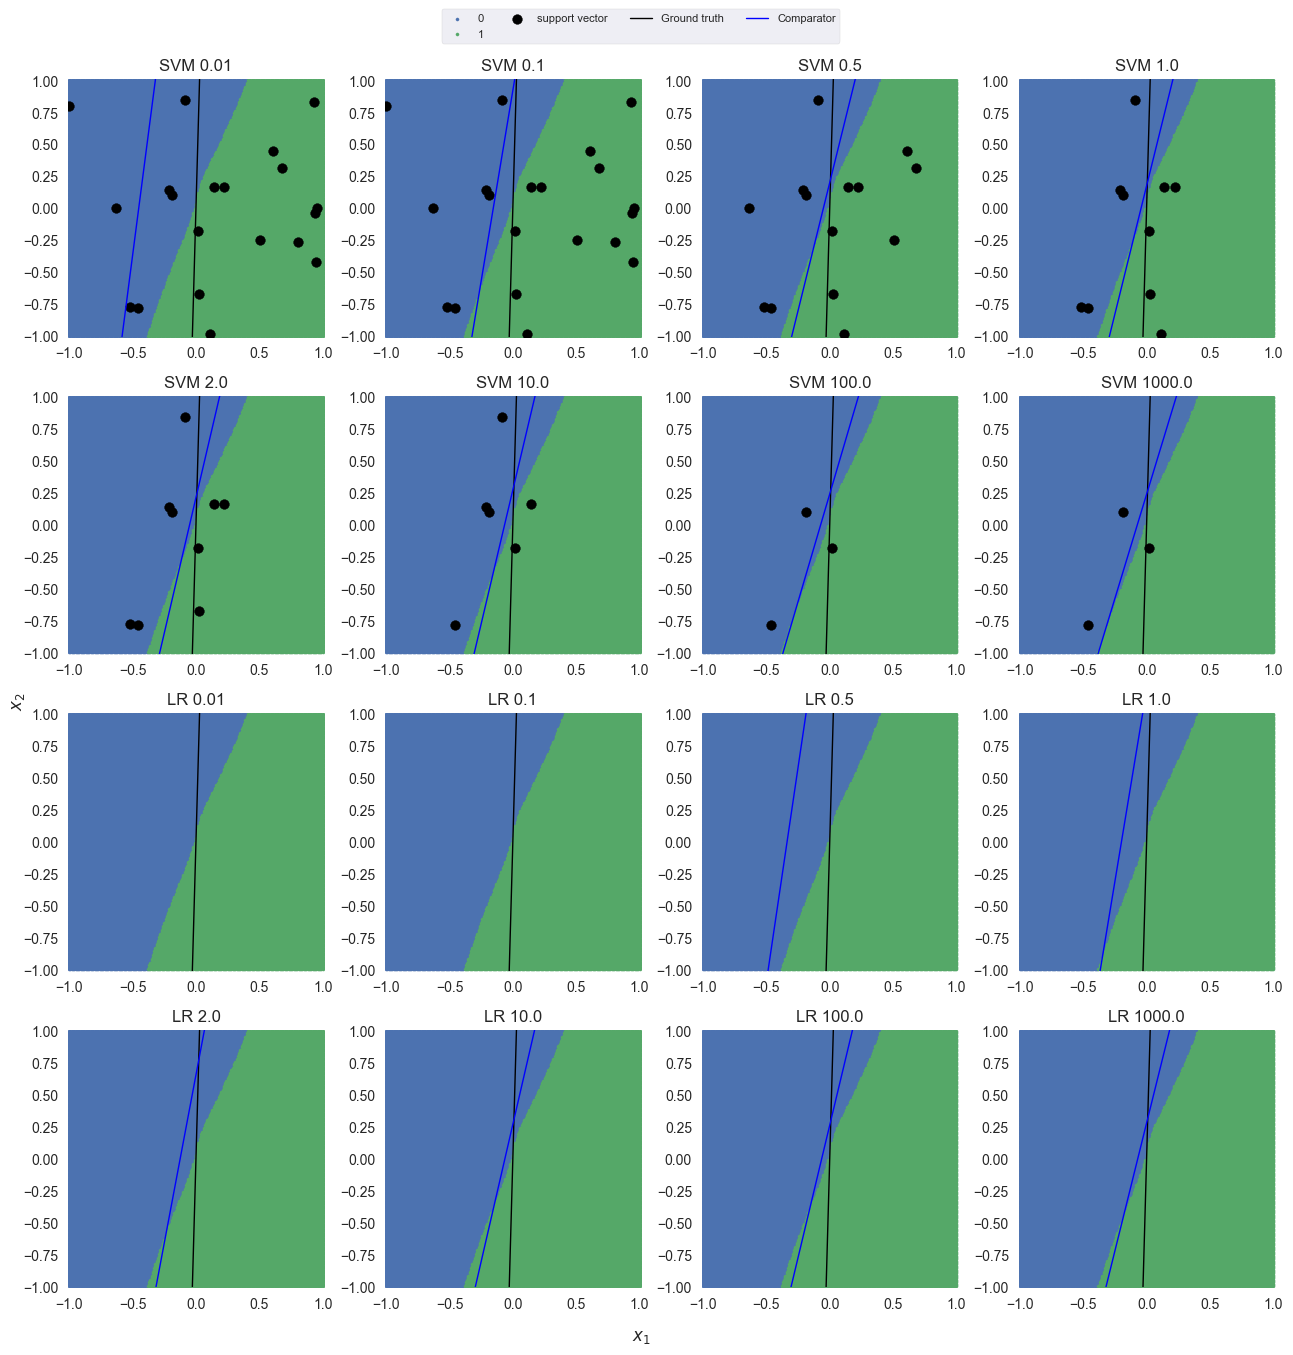

In [20]:
for task_i in range(num_tasks):
    ncols = 4
    nrows = math.ceil(num_models / ncols)
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    model_classes = {
        "SVM": res[task_i]["svm"],
        "LR": res[task_i]["lr"],
    }

    llm_preds = model_preds[task_i]["llm"]
    llm_pred_labels = np.argmax(llm_preds, axis=-1)

    model_i = 0
    for model_class, models in model_classes.items():
        for reg_coef, model in models.items():
            model_out = (
                -(np.array(input_range) * model[0].coef_[0, 0] + model[0].intercept_[0])
                / model[0].coef_[0, 1]
            )

            if nrows == 1:
                ax = axes[model_i]
            else:
                ax = axes[model_i // ncols, model_i % ncols]

            for possible_label in [0, 1]:
                idxes = np.where(llm_pred_labels == possible_label)
                ax.scatter(
                    test_queries[idxes][:, 0],
                    test_queries[idxes][:, 1],
                    label=f"{possible_label}" if model_i == 0 else "",
                    s=5,
                )

            if model_class == "SVM":
                ax.scatter(
                    svm_info[task_i][reg_coef]["support_vectors"][:, 0],
                    svm_info[task_i][reg_coef]["support_vectors"][:, 1],
                    label="support vector" if model_i == 0 else "",
                    color="black"
                )

            ax.plot(
                np.array(input_range),
                res[task_i]["gt"],
                label="Ground truth" if model_i == 0 else "",
                color="black",
                linewidth=1,
            )

            ax.plot(np.array(input_range), model_out, color="blue", linewidth=1, label="Comparator" if model_i == 0 else "")

            ax.set_xlim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_ylim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_title(f"{model_class} {reg_coef}")
            model_i += 1


    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8",
    )
    fig.supxlabel("$x_1$")
    fig.supylabel("$x_2$")
    plt.tight_layout()
    plt.show()

### Mean 0-1 Prediction Difference

In [21]:
losses = {}

for task_i in range(num_tasks):
    model_classes = {
        "SVM": res[task_i]["svm"],
        "LR": res[task_i]["lr"],
        "KNN": res[task_i]["knn"],
    }

    llm_preds = np.argmax(model_preds[task_i]["llm"], axis=1)
    for model_class, models in model_classes.items():
        for reg_coef, model in models.items():
            losses.setdefault((model_class, reg_coef), [])
            losses[(model_class, reg_coef)].append(np.mean(model.predict(test_queries) == llm_preds))

for model_info, curr_loss in losses.items():
    print("{}: {:.2f}% +/- {:.2f}".format(model_info, np.mean(curr_loss) * 100, np.std(curr_loss * 100)))

('SVM', 0.01): 77.74% +/- 0.00
('SVM', 0.1): 92.03% +/- 0.00
('SVM', 0.5): 96.24% +/- 0.00
('SVM', 1.0): 96.31% +/- 0.00
('SVM', 2.0): 95.91% +/- 0.00
('SVM', 10.0): 95.71% +/- 0.00
('SVM', 100.0): 96.56% +/- 0.00
('SVM', 1000.0): 96.55% +/- 0.00
('LR', 0.01): 50.19% +/- 0.00
('LR', 0.1): 50.19% +/- 0.00
('LR', 0.5): 83.46% +/- 0.00
('LR', 1.0): 90.32% +/- 0.00
('LR', 2.0): 93.32% +/- 0.00
('LR', 10.0): 95.64% +/- 0.00
('LR', 100.0): 95.81% +/- 0.00
('LR', 1000.0): 95.87% +/- 0.00
('KNN', 1): 95.09% +/- 0.00
('KNN', 3): 92.44% +/- 0.00


### Context Using Support Vector

In [22]:
if query_pred_only:
    def get_new_pairs(support_vectors, support_labels, query, context_len):
        support_vectors = jnp.concatenate((
            jnp.zeros((context_len - len(support_vectors), *support_vectors.shape[1:])),
            support_vectors,
            query,
        ))
        support_labels = jnp.concatenate((
            jnp.zeros((context_len - len(support_labels), *support_labels.shape[1:])),
            support_labels,
        ))
        return support_vectors, support_labels
else:
    def get_new_pairs(support_vectors, support_labels, query, context_len):
        support_vectors = jnp.concatenate((
            support_vectors,
            query,
            jnp.zeros((context_len - len(support_vectors), *support_vectors.shape[1:])),
        ))
        support_labels = jnp.concatenate((
            support_labels,
            jnp.zeros((context_len - len(support_labels), *support_labels.shape[1:])),
        ))
        return support_vectors, support_labels


/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_90464/2007038734.py:158: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


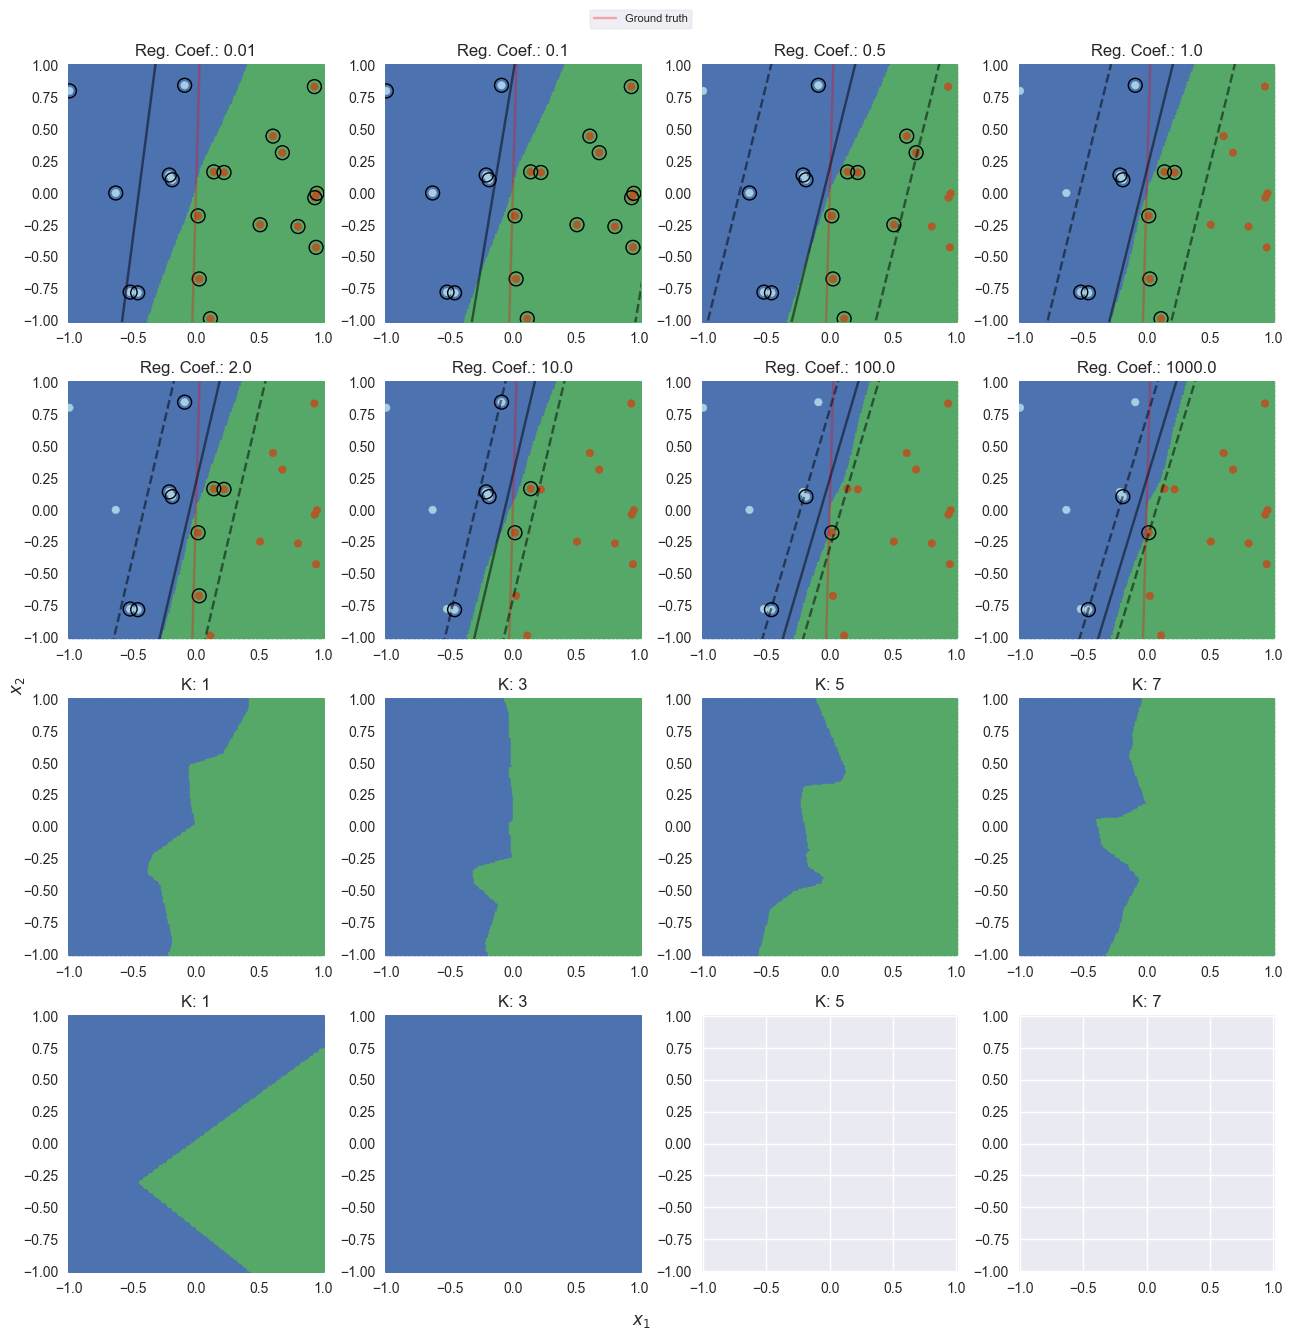

In [23]:
context_res = {}

for task_i in range(num_tasks):
    context_res.setdefault(task_i, {})

    ncols = 4
    nrows = math.ceil(len(svm_regs) / ncols)
    fig, axes = plt.subplots(
        nrows + 2,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows + 2, ncols), False),
        layout="constrained",
    )

    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    for idx, svm_reg in enumerate(svm_regs):
        if nrows == 1:
            ax = axes[idx]
        else:
            ax = axes[idx // ncols, idx % ncols]
        support_vectors = svm_info[task_i][svm_reg]["support_vectors"]
        support_labels = svm_info[task_i][svm_reg]["support_labels"]
        
        num_support_vectors = len(support_vectors)
        inputs, outputs = jax.vmap(get_new_pairs, in_axes=[None, None, 0, None])(
            support_vectors,
            support_labels,
            test_queries[:, None],
            context_len
        )

        # Use support vectors as context
        llm_preds, _ = llm_model.forward(
            params[CONST_MODEL_DICT][CONST_MODEL],
            inputs[:, [-1]],
            {
                CONST_CONTEXT_INPUT: inputs[:, :-1],
                CONST_CONTEXT_OUTPUT: outputs,
            },
        )
        if not query_pred_only:  
            llm_preds = llm_preds[:, num_support_vectors]
        context_res[task_i]["llm"] = llm_preds
        context_res[task_i]["support_vectors"] = support_vectors
        context_res[task_i]["support_labels"] = support_labels

        llm_pred_labels = np.argmax(llm_preds, axis=-1)

        for possible_label in [0, 1]:
            idxes = np.where(llm_pred_labels == possible_label)
            if len(idxes[0]) == 0:
                continue
            ax.scatter(
                test_queries[idxes][:, 0],
                test_queries[idxes][:, 1],
                label=f"{possible_label}" if model_i == 0 else "",
                s=5,
            )

        ax.plot(
            np.array(input_range),
            res[task_i]["gt"],
            label="Ground truth" if idx == 0 else "",
            color="red",
            alpha=0.3,
        )

        ax.scatter(
            context_inputs[:, 0],
            context_inputs[:, 1],
            c=context_outputs[:, -1],
            s=30,
            cmap=plt.cm.Paired,
        )
        DecisionBoundaryDisplay.from_estimator(
            res[task_i]["svm"][svm_reg],
            context_inputs,
            ax=ax,
            grid_resolution=50,
            plot_method="contour",
            colors="k",
            levels=[-1, 0, 1],
            alpha=0.5,
            linestyles=["--", "-", "--"],
        )
        ax.scatter(
            svm_info[task_i][svm_reg]["support_vectors"][:, 0],
            svm_info[task_i][svm_reg]["support_vectors"][:, 1],
            s=100,
            linewidth=1,
            facecolors="none",
            edgecolors="k",
        )
        ax.set_xlim(input_range[0] - 0.01, input_range[1] + 0.01)
        ax.set_ylim(input_range[0] - 0.01, input_range[1] + 0.01)
        ax.set_title(f"Reg. Coef.: {svm_reg}")

    for idx, k in enumerate([1, 3, 5, 7]):
        if nrows == 1:
            ax = axes[idx]
        else:
            ax = axes[nrows, idx % ncols]

        knn = make_knn(context_inputs, context_outputs, k)
        knn_preds = knn.predict(test_queries)
        
        for possible_label in [0, 1]:
            idxes = np.where(knn_preds == possible_label)
            if len(idxes[0]) == 0:
                continue
            ax.scatter(
                test_queries[idxes][:, 0],
                test_queries[idxes][:, 1],
                label=f"{possible_label}" if model_i == 0 else "",
                s=5,
            )
        ax.set_xlim(input_range[0] - 0.01, input_range[1] + 0.01)
        ax.set_ylim(input_range[0] - 0.01, input_range[1] + 0.01)
        ax.set_title(f"K: {k}")

    for idx, k in enumerate([1, 3, 5, 7]):
        if nrows == 1:
            ax = axes[idx]
        else:
            ax = axes[nrows + 1, idx % ncols]
        
        ax.set_title(f"K: {k}")
        ax.set_xlim(input_range[0] - 0.01, input_range[1] + 0.01)
        ax.set_ylim(input_range[0] - 0.01, input_range[1] + 0.01)
        if len(support_vectors) < k:
            continue

        knn = make_knn(support_vectors, support_labels, k)
        knn_preds = knn.predict(test_queries)
        for possible_label in [0, 1]:
            idxes = np.where(knn_preds == possible_label)
            if len(idxes[0]) == 0:
                continue
            ax.scatter(
                test_queries[idxes][:, 0],
                test_queries[idxes][:, 1],
                label=f"{possible_label}" if model_i == 0 else "",
                s=5,
            )

    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=3,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8",
    )
    fig.supxlabel("$x_1$")
    fig.supylabel("$x_2$")
    plt.tight_layout()
    plt.show()

In [24]:
support_vector_losses = {}

for task_i in range(num_tasks):
    model_classes = {
        "SVM": res[task_i]["svm"],
        "LR": res[task_i]["lr"],
        "KNN": res[task_i]["knn"],
    }

    llm_preds = np.argmax(context_res[task_i]["llm"], axis=1)
    for model_class, models in model_classes.items():
        for reg_coef, model in models.items():
            support_vector_losses.setdefault((model_class, reg_coef), [])
            support_vector_losses[(model_class, reg_coef)].append(np.mean(model.predict(test_queries) == llm_preds))

for model_info, curr_loss in support_vector_losses.items():
    print("{}: {:.2f}% +/- {:.2f}".format(model_info, np.mean(curr_loss) * 100, np.std(curr_loss * 100)))

('SVM', 0.01): 76.08% +/- 0.00
('SVM', 0.1): 90.87% +/- 0.00
('SVM', 0.5): 96.08% +/- 0.00
('SVM', 1.0): 96.39% +/- 0.00
('SVM', 2.0): 96.03% +/- 0.00
('SVM', 10.0): 95.30% +/- 0.00
('SVM', 100.0): 94.99% +/- 0.00
('SVM', 1000.0): 94.90% +/- 0.00
('LR', 0.01): 48.53% +/- 0.00
('LR', 0.1): 48.53% +/- 0.00
('LR', 0.5): 81.80% +/- 0.00
('LR', 1.0): 88.70% +/- 0.00
('LR', 2.0): 92.34% +/- 0.00
('LR', 10.0): 95.43% +/- 0.00
('LR', 100.0): 95.40% +/- 0.00
('LR', 1000.0): 95.11% +/- 0.00
('KNN', 1): 93.67% +/- 0.00
('KNN', 3): 93.31% +/- 0.00


### Permute Support Vectors

/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_90464/1086479219.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


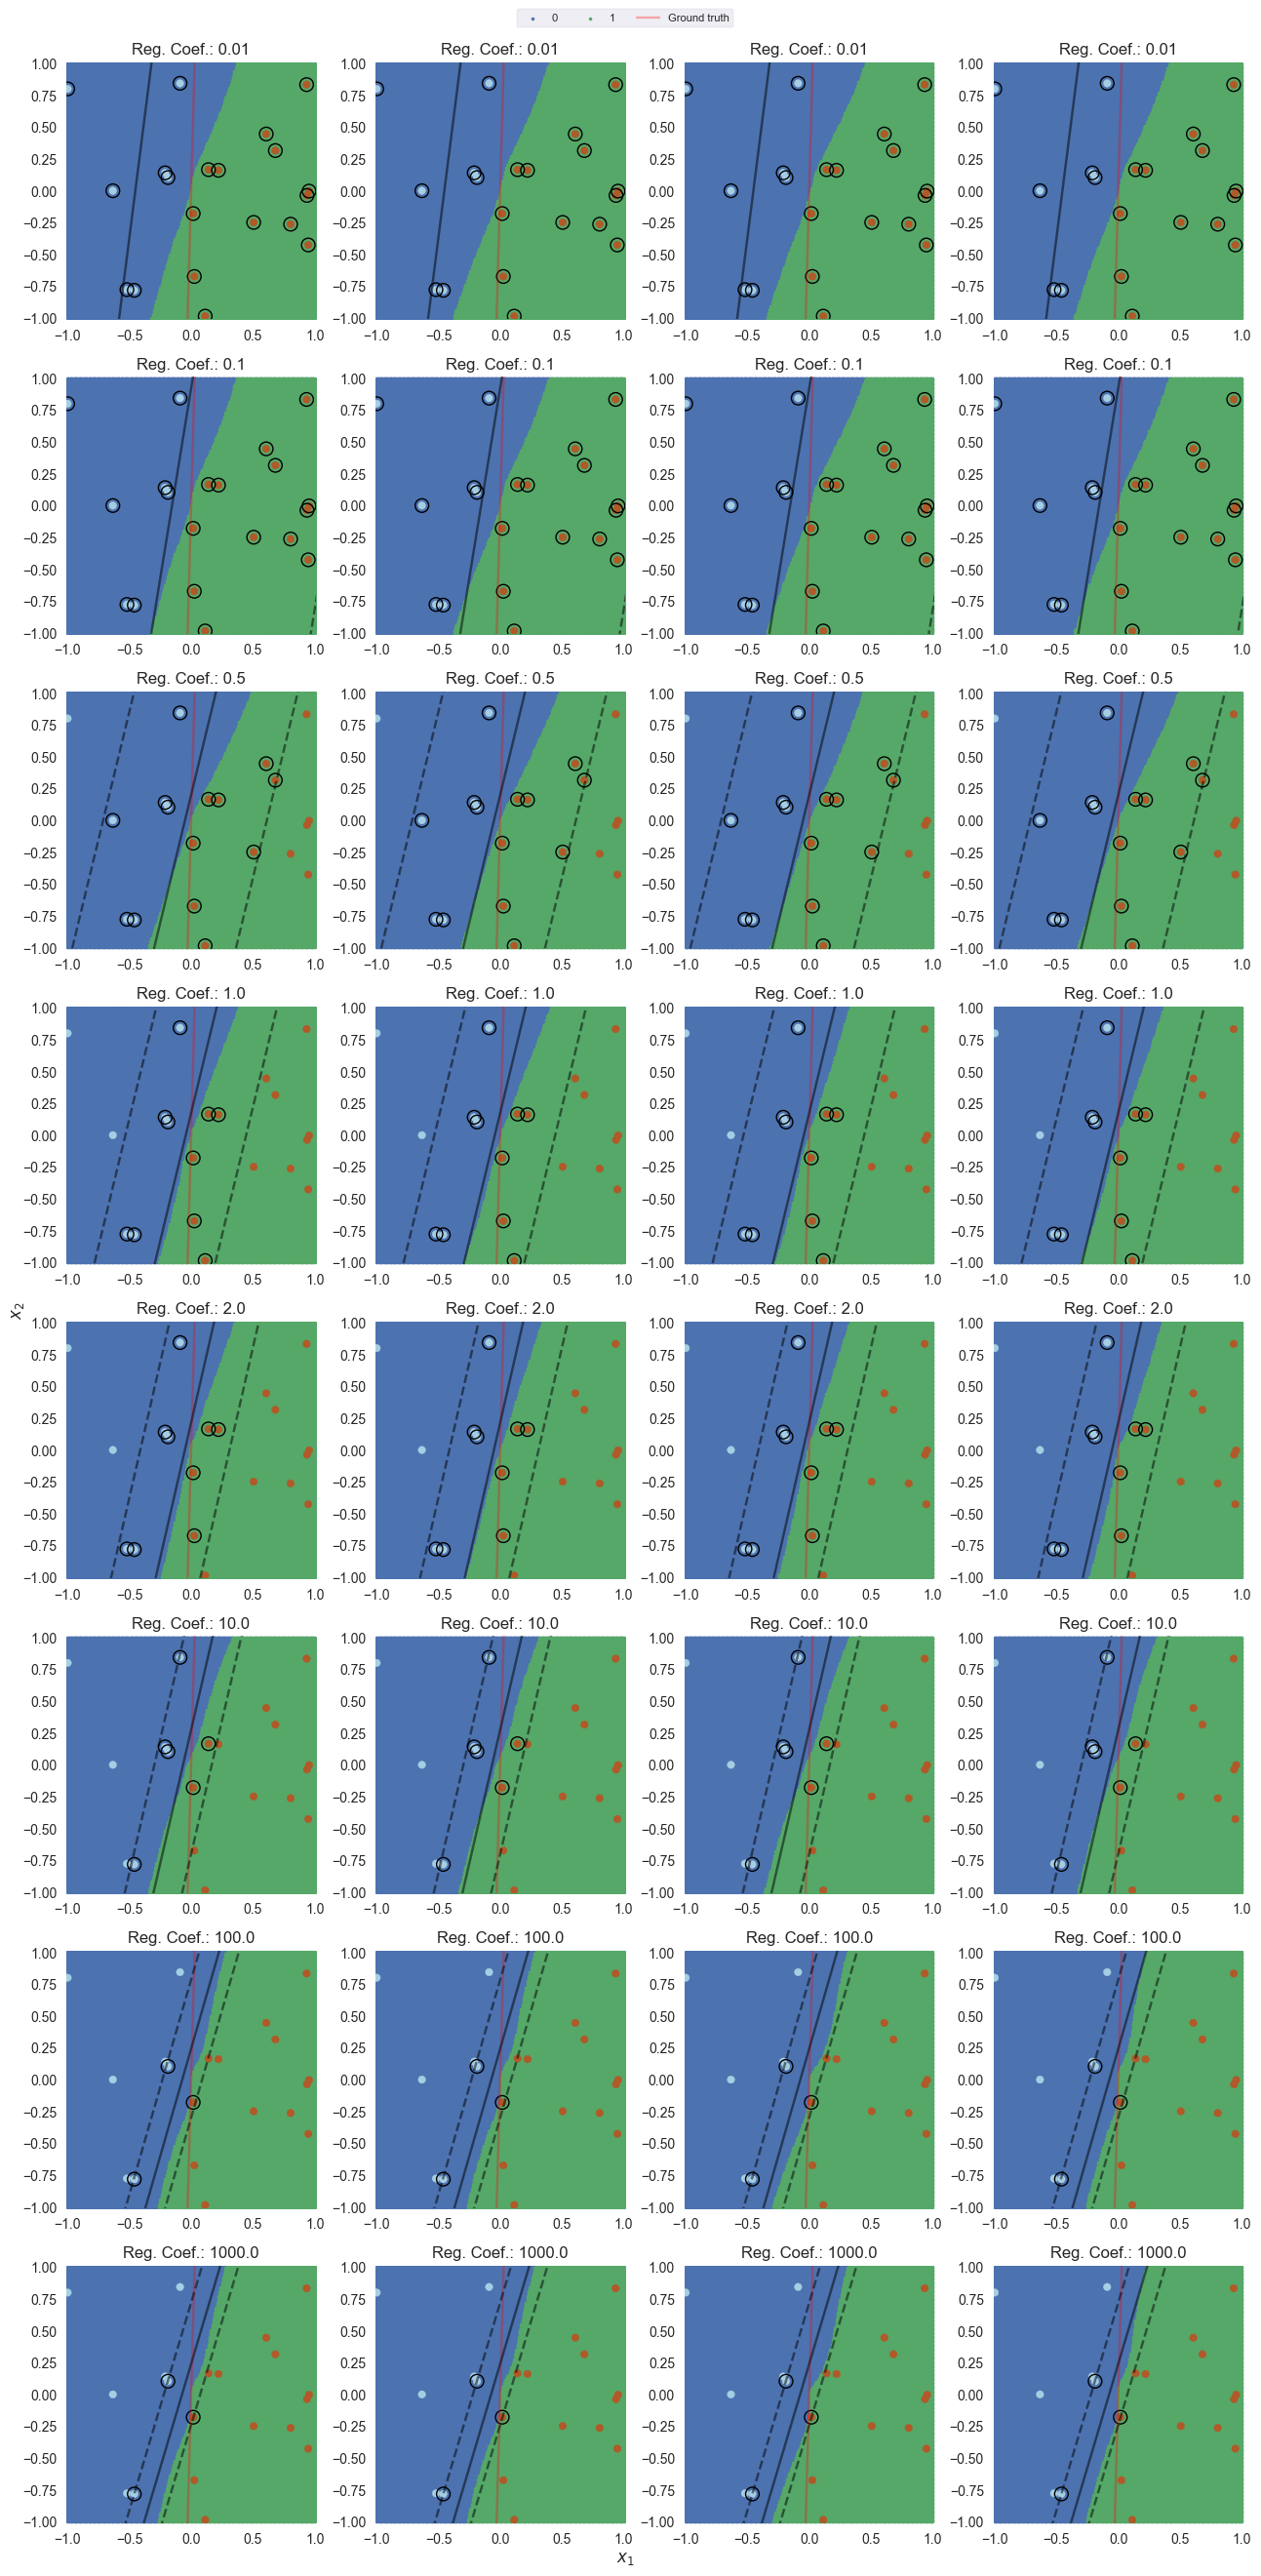

In [25]:
permute_res = {}

num_permutations = 4
perm_seed = 9999

permutation_keys = jrandom.split(jrandom.PRNGKey(perm_seed), 4)

for task_i in range(num_tasks):
    permute_res.setdefault(task_i, {})

    ncols = 4
    nrows = math.ceil((len(svm_regs) * num_permutations) / ncols)
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    ax_idx = 0
    for idx, svm_reg in enumerate(svm_regs):
        for permutation_key in permutation_keys:
            if nrows == 1:
                ax = axes[ax_idx]
            else:
                ax = axes[ax_idx // ncols, ax_idx % ncols]
            support_vectors = svm_info[task_i][svm_reg]["support_vectors"]
            support_labels = svm_info[task_i][svm_reg]["support_labels"]

            perm_idxes = jrandom.permutation(permutation_key, x=np.arange(len(support_vectors)))
            support_vectors = support_vectors[perm_idxes]
            support_labels = support_labels[perm_idxes]

            num_support_vectors = len(support_vectors)
            inputs, outputs = jax.vmap(get_new_pairs, in_axes=[None, None, 0, None])(
                support_vectors,
                support_labels,
                test_queries[:, None],
                context_len
            )

            # Use support vectors as context
            llm_preds, _ = llm_model.forward(
                params[CONST_MODEL_DICT][CONST_MODEL],
                inputs[:, [-1]],
                {
                    CONST_CONTEXT_INPUT: inputs[:, :-1],
                    CONST_CONTEXT_OUTPUT: outputs,
                },
            )
            if not query_pred_only:  
                llm_preds = llm_preds[:, num_support_vectors]
            permute_res[task_i]["llm"] = llm_preds
            permute_res[task_i]["support_vectors"] = support_vectors
            permute_res[task_i]["support_labels"] = support_labels

            llm_pred_labels = np.argmax(llm_preds, axis=-1)

            for possible_label in [0, 1]:
                idxes = np.where(llm_pred_labels == possible_label)
                if len(idxes[0]) == 0:
                    continue
                ax.scatter(
                    test_queries[idxes][:, 0],
                    test_queries[idxes][:, 1],
                    label=f"{possible_label}" if ax_idx == 0 else "",
                    s=5,
                )

            ax.plot(
                np.array(input_range),
                res[task_i]["gt"],
                label="Ground truth" if ax_idx == 0 else "",
                color="red",
                alpha=0.3,
            )

            ax.scatter(
                context_inputs[:, 0],
                context_inputs[:, 1],
                c=context_outputs[:, -1],
                s=30,
                cmap=plt.cm.Paired,
            )
            DecisionBoundaryDisplay.from_estimator(
                res[task_i]["svm"][svm_reg],
                context_inputs,
                ax=ax,
                grid_resolution=50,
                plot_method="contour",
                colors="k",
                levels=[-1, 0, 1],
                alpha=0.5,
                linestyles=["--", "-", "--"],
            )
            ax.scatter(
                svm_info[task_i][svm_reg]["support_vectors"][:, 0],
                svm_info[task_i][svm_reg]["support_vectors"][:, 1],
                s=100,
                linewidth=1,
                facecolors="none",
                edgecolors="k",
            )
            ax.set_xlim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_ylim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_title(f"Reg. Coef.: {svm_reg}")
            ax_idx += 1

    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=3,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8",
    )
    fig.supxlabel("$x_1$")
    fig.supylabel("$x_2$")
    plt.tight_layout()
    plt.show()

## Examplar Length

In [26]:
ex_len_res = {
    "llm": {},
    "lr": {},
    "svm": {},
}
loss_per_examplar_len = {}

for task_i in range(num_tasks):
    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]
    
    for examplar_len in range(2, context_len):
        for model_class in ex_len_res:
            ex_len_res[model_class].setdefault(examplar_len, [])
        loss_per_examplar_len.setdefault(examplar_len, [])
        inputs, outputs = jax.vmap(get_new_pairs, in_axes=[None, None, 0, None])(
            context_inputs[:examplar_len],
            context_outputs[:examplar_len],
            test_queries[:, None],
            context_len
        )

        # Use support vectors as context
        llm_preds, _ = llm_model.forward(
            params[CONST_MODEL_DICT][CONST_MODEL],
            inputs[:, [-1]],
            {
                CONST_CONTEXT_INPUT: inputs[:, :-1],
                CONST_CONTEXT_OUTPUT: outputs,
            },
        )
        if not query_pred_only:  
            llm_preds = llm_preds[:, examplar_len]
        loss = np.mean(np.argmax(llm_preds, axis=-1) != np.argmax(model_preds[task_i]["gt"], axis=-1))
        ex_len_res["llm"][examplar_len].append(loss)

        if len(np.unique(np.argmax(context_outputs[:examplar_len], axis=-1))) > 1:
            svm = make_svm(context_inputs[:examplar_len], context_outputs[:examplar_len], svm_regs[-1])
            preds = svm.predict(test_queries)
            loss = np.mean(preds != np.argmax(model_preds[task_i]["gt"], axis=-1))
            ex_len_res["svm"][examplar_len].append(loss)
            lr = make_lr(context_inputs[:examplar_len], context_outputs[:examplar_len], "l2", lr_regs[-1])
            preds = lr.predict(test_queries)
            loss = np.mean(preds != np.argmax(model_preds[task_i]["gt"], axis=-1))
            ex_len_res["lr"][examplar_len].append(loss)

        loss_per_examplar_len[examplar_len].append(loss)


/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expli

In [27]:
for examplar_len, losses in loss_per_examplar_len.items():
    print("Examplar Length: {}, Loss - mean: {} std: {}".format(examplar_len, np.mean(losses), np.std(losses)))

Examplar Length: 2, Loss - mean: 0.30343306064605713 std: 0.0
Examplar Length: 3, Loss - mean: 0.1435112992252667 std: 0.0
Examplar Length: 4, Loss - mean: 0.1946733991732878 std: 0.0
Examplar Length: 5, Loss - mean: 0.20662854879829706 std: 0.0
Examplar Length: 6, Loss - mean: 0.30608153263533083 std: 0.0
Examplar Length: 7, Loss - mean: 0.02542016286725576 std: 0.0
Examplar Length: 8, Loss - mean: 0.02544491472983342 std: 0.0
Examplar Length: 9, Loss - mean: 0.02836563451399718 std: 0.0
Examplar Length: 10, Loss - mean: 0.04537016410484889 std: 0.0
Examplar Length: 11, Loss - mean: 0.04616222370733398 std: 0.0
Examplar Length: 12, Loss - mean: 0.04133561050469048 std: 0.0
Examplar Length: 13, Loss - mean: 0.05051855152100196 std: 0.0
Examplar Length: 14, Loss - mean: 0.05054330338357962 std: 0.0
Examplar Length: 15, Loss - mean: 0.06061731145268681 std: 0.0
Examplar Length: 16, Loss - mean: 0.06064206331526447 std: 0.0
Examplar Length: 17, Loss - mean: 0.06064206331526447 std: 0.0
Ex

/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folde

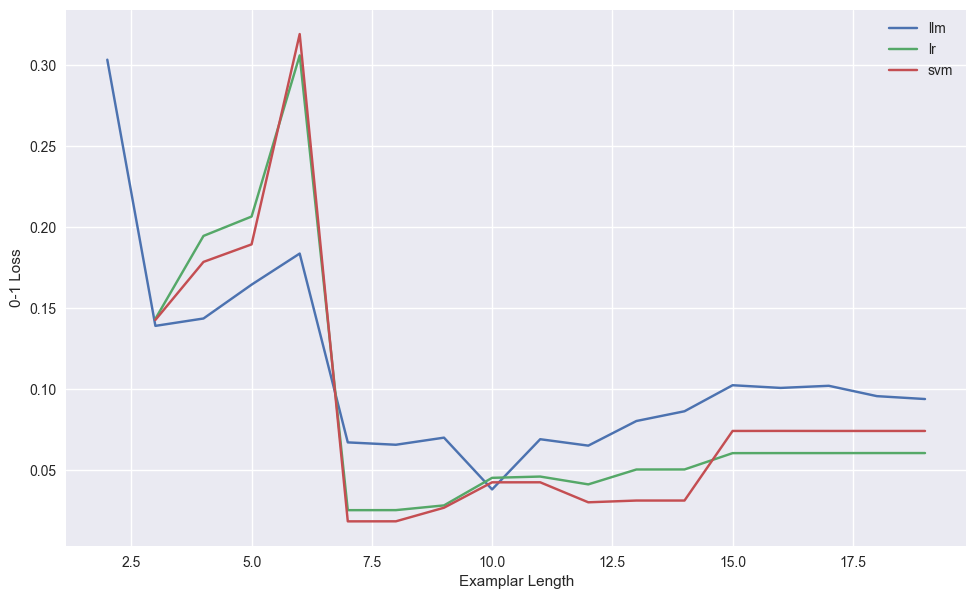

In [28]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(
    nrows,
    ncols,
    figsize=set_size(750, 0.95, (nrows, ncols), True),
    layout="constrained",
)

for model_class, examplar_lens in ex_len_res.items():
    xs = np.array((list(examplar_lens.keys())))
    ys = np.array([np.mean(losses) for losses in examplar_lens.values()])
    stds = np.array([np.std(losses) for losses in examplar_lens.values()])
    sort_idxes = np.argsort(xs)
    xs = xs[sort_idxes]
    ys = ys[sort_idxes]
    ax.plot(xs, ys, label=model_class)
    ax.fill_between(xs, ys + stds, ys - stds, alpha=0.1)
ax.legend()
ax.set_ylabel("0-1 Loss")
ax.set_xlabel("Examplar Length")
fig.tight_layout()
plt.show()

## Check SVM in Representation Space

In [29]:
task_i = 0
context_inputs = res[task_i]["data"]["context_inputs"]
context_outputs = res[task_i]["data"]["context_outputs"]

print(test_queries.shape, context_inputs.shape)

inputs, outputs = jax.vmap(get_new_pairs, in_axes=[None, None, 0, None])(
    context_inputs,
    context_outputs,
    context_inputs[:, None],
    context_len
)

print(inputs.shape, outputs.shape)

repr, _ = llm_model.get_latent(
    params[CONST_MODEL_DICT][CONST_MODEL],
    inputs[:, [-1]],
    {
        CONST_CONTEXT_INPUT: inputs[:, :-1],
        CONST_CONTEXT_OUTPUT: outputs,
    },
)
print(repr.shape)

last_reprs = repr[:, -1]
print(last_reprs.shape)

(40401, 2) (20, 2)
(20, 21, 2) (20, 20, 2)
(20, 41, 32)
(20, 32)


In [30]:
train_y = np.argmax(context_outputs, axis=-1)
train_y[train_y == 0] = -1

In [31]:
loss, primal_sol_repr = primal_svm(last_reprs, train_y)
print(loss)

loss, primal_sol_input = primal_svm(context_inputs, train_y)
print(loss)

0.2449054231975643
25.826637740829824


In [32]:
loss, dual_sol_repr = dual_svm(last_reprs, train_y)
print(loss)
print(np.where(np.abs(dual_sol_repr) > 1e-10))

loss, dual_sol_input = dual_svm(context_inputs, train_y)
print(loss)
print(np.where(np.abs(dual_sol_input) > 1e-10))

-0.24490540992312987
(array([ 1,  8,  9, 12]),)
-25.82663774082983
(array([ 1, 11, 14]),)


Quickly sanity check support vectors with Scikit-Learn vs CVXPY

In [33]:
repr_svm = make_svm(last_reprs, context_outputs, 1000.0)
decision_function = repr_svm.decision_function(last_reprs)
support_vector_indices = np.where(np.abs(decision_function) <= 1)[0]
print(support_vector_indices)
print(svm_info[task_i][svm_regs[-1]]["support_vector_indices"])


[ 1  9 12]
[ 1 11 14]


/Users/chanb/research/personal/jaxl/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [41]:
print(*primal_sol_input)

6.869585245070979 -2.112362194881063 0.5035952970576938


In [35]:
recovered_weights = np.sum((dual_sol_input * train_y)[:, None] * context_inputs, axis=0)

support_vector_index = np.where(np.abs(dual_sol_input) > 1e-10)[0][0]
recovered_bias = train_y[support_vector_index] - np.dot(recovered_weights, context_inputs[support_vector_index])
print(*recovered_weights, recovered_bias)

6.86958524507098 -2.1123621948810616 0.5035952970576947


Recover the primal parameters from the dual derived in representation space

In [36]:
recovered_weights = np.sum((dual_sol_repr * train_y)[:, None] * context_inputs, axis=0)

support_vector_index = np.where(np.abs(dual_sol_repr) > 1e-10)[0][0]
recovered_bias = train_y[support_vector_index] - np.dot(recovered_weights, context_inputs[support_vector_index])
print(*recovered_weights, recovered_bias)

0.11193866612589187 0.001970070344813446 -0.947009149349511


Compare the dual parameters from the input and representation spaces

In [37]:
print(dual_sol_input)
print(dual_sol_repr)

[-3.63467461e-21  5.85494285e+00 -2.87602442e-20 -1.39035870e-20
 -1.77118765e-20 -6.39588118e-21 -5.52224858e-21 -2.33995879e-20
 -3.82726615e-21 -1.20225966e-20 -1.77520769e-20  1.99716949e+01
 -1.03324342e-20 -1.65407963e-20  2.58266377e+01 -3.09832926e-20
 -2.97022292e-20 -1.12830452e-20 -2.75850671e-20 -1.93458666e-20]
[ 1.30665827e-23  2.20692884e-01  1.39146272e-23 -3.04720251e-24
 -8.77546090e-27 -2.85046874e-27 -2.61357000e-23 -2.59498014e-24
  1.75540074e-02  2.42125260e-02  3.14494731e-23  8.73817261e-25
  2.27351403e-01 -3.00699469e-24  7.57994448e-23  1.42325253e-23
 -5.59627771e-24  6.04228207e-24  1.54299582e-23  1.60079463e-23]


In [42]:
params[CONST_MODEL_DICT][CONST_MODEL][CONST_PREDICTOR]["params"]["kernel"][:, 0] - params[CONST_MODEL_DICT][CONST_MODEL][CONST_PREDICTOR]["params"]["kernel"][:, 1]

array([-7.5474381e-06,  3.8308635e-02, -5.5489087e-01, -2.2705930e-01,
        5.7224041e-01,  7.9549062e-01, -1.2404834e-01, -8.4409428e-01,
       -5.7786560e-01, -9.0696380e-02,  2.9262757e-01,  6.9772732e-01,
       -7.0694834e-05, -9.3574941e-02, -1.1847163e+00,  1.6611984e-01,
        1.8477440e-06, -7.8400660e-01,  1.1632570e+00, -3.4245628e-01,
       -5.0900131e-04,  1.8619731e-01,  4.3843782e-01, -2.0484897e-01,
       -6.7835778e-01, -5.3319228e-01,  1.3304046e-01,  4.6083388e-01,
       -2.3834613e-01, -4.8731199e-01, -3.9240640e-01,  5.9852004e-01],
      dtype=float32)

In [40]:
primal_sol_repr

array([ 7.37118421e-07, -1.74503774e-02,  1.63573883e-01,  3.65473461e-02,
       -1.74902987e-01, -2.40444974e-01, -7.50942541e-02,  2.78944172e-01,
        2.31974845e-01,  1.83375201e-02, -8.27365705e-02, -6.78806991e-02,
       -5.12352392e-06,  9.56999984e-02,  1.68329048e-01, -1.05306403e-01,
       -3.46961955e-07,  1.69685001e-01, -2.40396624e-01, -4.84308309e-02,
        1.91109354e-05, -1.26423160e-01, -4.78620938e-02, -1.26258690e-02,
        2.09967564e-01, -9.67424931e-03, -9.36930334e-03,  3.02258146e-02,
       -2.79508749e-02,  4.77392207e-02,  9.64617780e-02, -1.02310542e-01,
       -4.69051676e-01])

Distance of primal parameters

In [44]:
np.linalg.norm(params[CONST_MODEL_DICT][CONST_MODEL][CONST_PREDICTOR]["params"]["kernel"][:, 0] - params[CONST_MODEL_DICT][CONST_MODEL][CONST_PREDICTOR]["params"]["kernel"][:, 1] - primal_sol_repr[:-1])

3.5335236565818935